In [1]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

# spikes, behavior, coordinates, df, stimulus = loaddata()

"""
to dump:

path = os.path.dirname(os.getcwd())
pickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))

to load:

check1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))
"""

"\nto dump:\n\npath = os.path.dirname(os.getcwd())\npickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))\n\nto load:\n\ncheck1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))\n"

In [3]:

######## Simulation parameters ########
neurons_per_pop = 20
n_pop = 3
n_batches = 500
T = 200
mean_fr = .1

######## Defining coordinate system ########
rads = torch.linspace(0, 2*torch.pi, n_pop+1)
mean_locations_pop = torch.zeros(n_pop, 2)
coordinates = torch.zeros(neurons_per_pop*n_pop, 2)
for i in range(n_pop):
    mean_locations_pop[i, :] = torch.tensor([torch.cos(rads[i]), torch.sin(rads[i])])
    coordinates[neurons_per_pop * i:neurons_per_pop * (i + 1), :] = 0.15 * torch.randn(neurons_per_pop, 2) + mean_locations_pop[i]

######## Start creating data ########
data = torch.zeros(neurons_per_pop*n_pop, T, n_batches)
for batch in range(n_batches):

    ######## Creating random input currents and mother trains ########
    t = np.linspace(0, 10*np.pi, T)
    fr = np.zeros((n_pop, T))
    mother = np.zeros((n_pop, T))
    for pop in range(n_pop):
        u = np.random.rand()
        phase = np.random.randn()
        amp = .1*np.random.rand()
        shift = .3*np.random.rand()
        fr[pop, :] = amp*np.sin(phase*(t + 2*np.pi*u)) + shift
        while np.min(fr[pop, :]) < 0:
            u = np.random.rand()
            phase = np.random.randn()
            amp = .1*np.random.rand()
            shift = .3*np.random.rand()
            fr[pop, :] = amp*np.sin(phase*(t + 2*np.pi*u)) + shift
        mother[pop, :] = np.random.poisson(fr[pop, :])


    # empty data array
    spikes = np.zeros((neurons_per_pop*n_pop, T))

    # Excitatory and inhibitory connections
    inh = [[0], [0], [0], [0], [0], [0]]
    exc = [[1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2]]
    for pop in range(n_pop):
        delete_spikes = np.roll(np.sum(fr[inh[pop], :], 0), 1) * np.ones((neurons_per_pop, T)) >= np.random.uniform(0, 1, size=(neurons_per_pop, T))
        noise = np.random.poisson(np.roll(np.sum(fr[exc[pop], :], 0), 1), (neurons_per_pop, T))
        temp = np.tile(mother[pop, :], (neurons_per_pop, 1)) - delete_spikes + noise
        spikes[pop*neurons_per_pop:(pop+1)*neurons_per_pop, :] = temp[np.argsort(np.mean(temp, 1)), :]
    spikes[spikes < 0] = 0
    spikes[spikes > 1] = 1

    data[:, :, batch] = torch.tensor(spikes)
print(torch.mean(data))


tensor(0.3420)


In [4]:
data_nsr = resample(data, 10, mode=1)
data_nsr1 = resample(data, 10, mode=2)

In [5]:
torch.sum((data_nsr-data_nsr1)**2)

tensor(247855.)

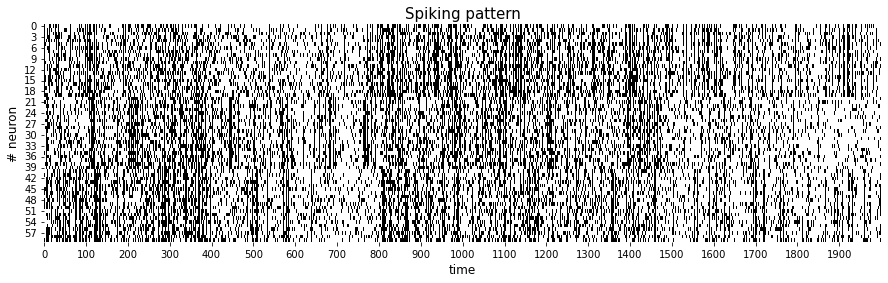

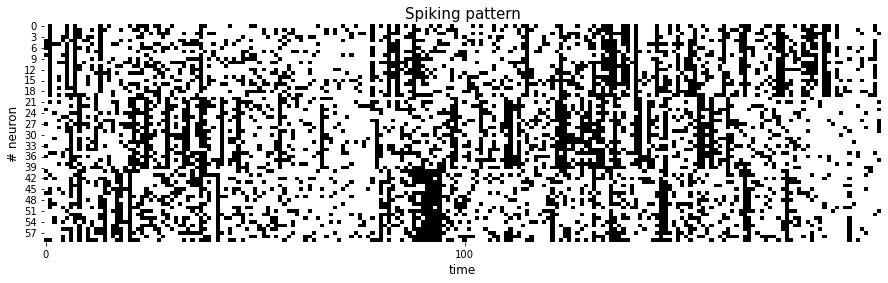

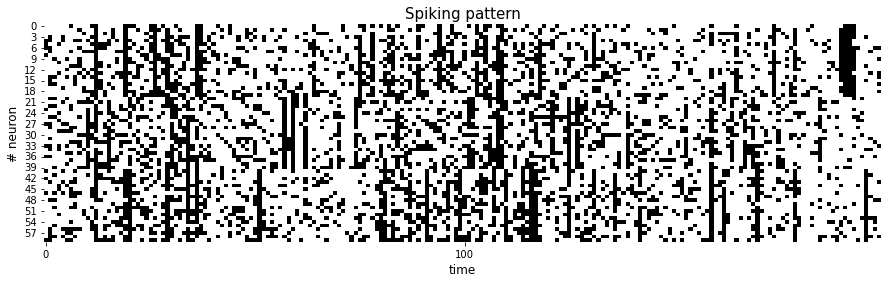

In [6]:
raster_plot(reshape(data[:, :, :10]))
plt.show()
raster_plot(reshape(data_nsr[:, :, :10]))
plt.show()
raster_plot(reshape(data_nsr1[:, :, :10]))
plt.show()


C:\Users\sebas\anaconda3\envs\RTRBM\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\sebas\anaconda3\envs\RTRBM\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\sebas\anaconda3\envs\RTRBM\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

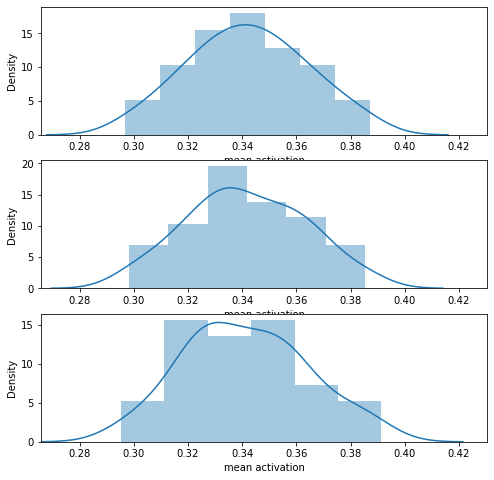

In [7]:
mean_data = torch.mean(data, (1, 2))
mean_data_nsr = torch.mean(data_nsr, (1, 2))
mean_data_nsr1 = torch.mean(data_nsr1, (1, 2))
minimum = torch.min(torch.cat([mean_data, mean_data_nsr, mean_data_nsr1]))
maximum = torch.max(torch.cat([mean_data, mean_data_nsr, mean_data_nsr1]))

fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.distplot(mean_data, ax=ax[0])
ax[0].set_xlabel('mean activation')
ax[0].set_xlim([0.9*minimum, 1.1*maximum])
sns.distplot(mean_data_nsr, ax=ax[1])
ax[1].set_xlabel('mean activation')
ax[1].set_xlim([0.9*minimum, 1.1*maximum])
sns.distplot(mean_data_nsr1, ax=ax[2])
ax[2].set_xlabel('mean activation')
ax[2].set_xlim([0.9*minimum, 1.1*maximum])
plt.show()


100%|██████████| 1000/1000 [3:32:05<00:00, 12.73s/it] 


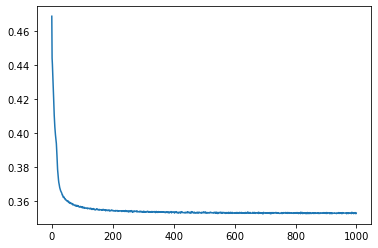

In [8]:
rtrbm_original_data = RTRBM(data, N_H=3, device='cpu')
rtrbm_original_data.learn(n_epochs=1000, batchsize=10, lr=1e-4)
plt.plot(rtrbm_original_data.errors)

100%|██████████| 1000/1000 [34:03<00:00,  2.04s/it]


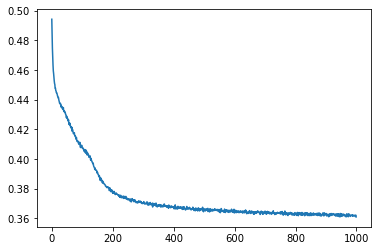

In [9]:
rtrbm_data_nsr = RTRBM(data_nsr, N_H=3, device='cpu')
rtrbm_data_nsr.learn(n_epochs=1000, batchsize=10, lr=1e-4)
plt.plot(rtrbm_data_nsr.errors)

100%|██████████| 1000/1000 [36:04<00:00,  2.16s/it]


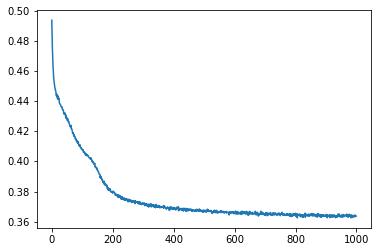

In [10]:
rtrbm_data_nsr1 = RTRBM(data_nsr1, N_H=3, device='cpu')
rtrbm_data_nsr1.learn(n_epochs=1000, batchsize=10, lr=1e-4)
plt.plot(rtrbm_data_nsr1.errors)

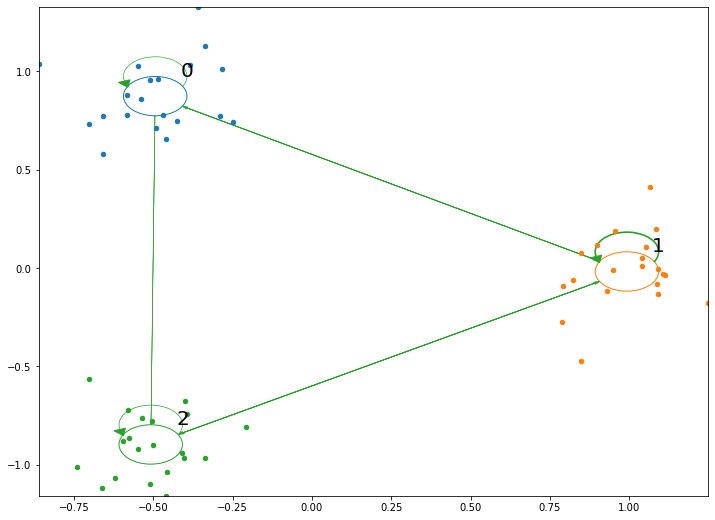

In [12]:
VH = rtrbm_original_data.W.detach().clone()
HH = rtrbm_original_data.W_acc.detach().clone()
rf = get_hidden_mean_receptive_fields(VH, coordinates, only_max_conn=False)
create_plot(VH, HH, rf,  coordinates, 0, weight_line_factor=0.6, hiddens_radius=0.1, hidden_weight_thresh=0)

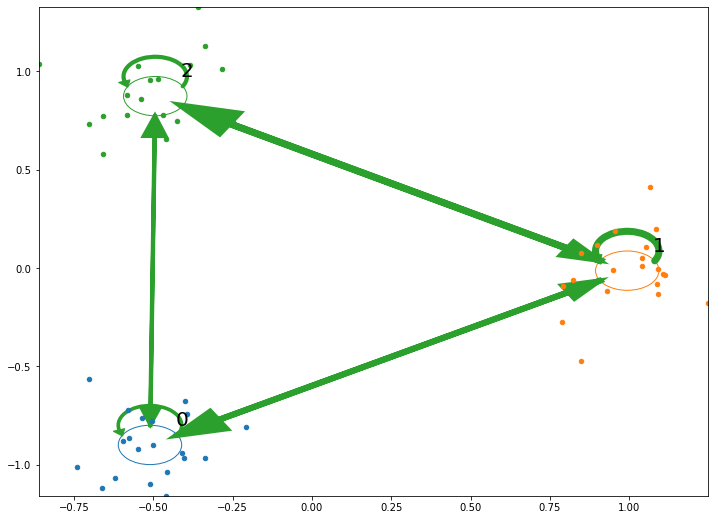

In [13]:
VH = rtrbm_data_nsr.W.detach().clone()
HH = rtrbm_data_nsr.W_acc.detach().clone()
rf = get_hidden_mean_receptive_fields(VH, coordinates, only_max_conn=False)
create_plot(VH, HH, rf,  coordinates, 0, weight_line_factor=0.6, hiddens_radius=0.1, hidden_weight_thresh=0)

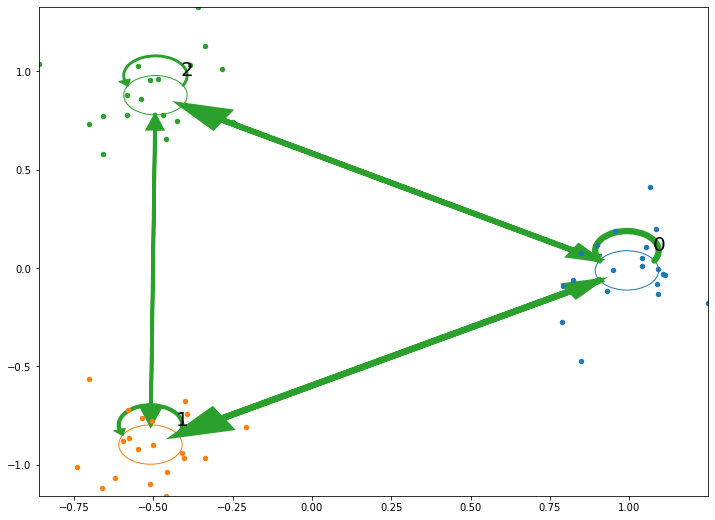

In [14]:
VH = rtrbm_data_nsr1.W.detach().clone()
HH = rtrbm_data_nsr1.W_acc.detach().clone()
rf = get_hidden_mean_receptive_fields(VH, coordinates, only_max_conn=False)
create_plot(VH, HH, rf,  coordinates, 0, weight_line_factor=0.6, hiddens_radius=0.1, hidden_weight_thresh=0)


In [11]:

import numpy as np
from math import cos, sin, atan2
from palettable.tableau import Tableau_10, Tableau_20
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, RegularPolygon
from numpy import radians as rad
import torch


def draw_neuron(x, y, neuron_radius, id=-1):
    # circle = plt.Circle((x, y), radius=neuron_radius, fill=False, color=Tableau_20.mpl_colors[2*id])
    # plt.gca().add_patch(circle)
    # plt.gca().text(x, y-(neuron_radius/4), str(id), size=neuron_radius*1000, ha='center')

    circle = plt.Circle((x, y), radius=neuron_radius, fill=False, color=Tableau_20.mpl_colors[2 * id])
    plt.gca().add_patch(circle)
    plt.gca().text(x + neuron_radius, y + neuron_radius, str(id), ha='center', fontsize=20)


def line_between_two_neurons(neuron1_x, neuron1_y, neuron2_x, neuron2_y, neuron_radius, weight=0.4,
                             weight_line_factor=1):
    angle = atan2(neuron2_x - neuron1_x, neuron2_y - neuron1_y)
    x_adjustment = neuron_radius * sin(angle)
    y_adjustment = neuron_radius * cos(angle)

    # assign colors to lines depending on the sign of the weight
    color = Tableau_10.mpl_colors[3]
    if weight > 0: color = Tableau_10.mpl_colors[2]

    # assign different linewidths to lines depending on the size of the weight
    abs_weight = abs(weight)
    linewidth = 2 * abs_weight * weight_line_factor

    # draw self-connecting arrow
    if neuron1_x == neuron2_x:
        drawCirc(plt.gca(), neuron_radius * 2, neuron1_x, neuron1_y, -30, 230, color_=color, lw=3 * linewidth)

    # draw arrow
    else:
        plt.gca().arrow(neuron1_x + x_adjustment, neuron1_y + y_adjustment,
                        neuron2_x - neuron1_x - 2 * x_adjustment, neuron2_y - neuron1_y - 2 * y_adjustment,
                        lw=3 * linewidth, color=color, length_includes_head=True, head_width=linewidth/20, overhang=0)

def drawCirc(ax, radius, centX, centY, angle_, theta2_, color_='black', lw=1):
    # ========Line
    if lw > 0.1:
        arc = Arc([centX, centY + radius / 2], radius, radius, angle=angle_,
                  theta1=0, theta2=theta2_, capstyle='round', linestyle='-', lw=lw, color=color_)
        ax.add_patch(arc)

        # ========Create the arrow head
        endX = centX + (radius / 2) * np.cos(rad(theta2_ + angle_))  # Do trig to determine end position
        endY = centY + (radius / 2) * np.sin(rad(theta2_ + angle_))

        ax.add_patch(  # Create triangle as arrow head
            RegularPolygon(
                (endX, endY + radius / 2),  # (x,y)
                3,  # number of vertices
                radius / 9,  # radius
                rad(angle_ + theta2_),  # orientation
                color=color_
            )
        )
    # ax.set_xlim([centX-radius,centY+radius]) and ax.set_ylim([centY-radius,centY+radius])
    # Make sure you keep the axes scaled or else arrow will distort


def plot_VH_connections(ax, VH, coordinates, strong_thresh=0.5, markersize=2):
    N_H, N_V = VH.shape
    max_hidden_connection = torch.max(VH, 0)[1]

    for h in range(N_H):
        ax.scatter(coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) > strong_thresh), 0],
                   coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) > strong_thresh), 1],
                   color=Tableau_20.mpl_colors[(2 * h) % 20], s=markersize)

        ax.scatter(coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) < strong_thresh), 0],
                   coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) < strong_thresh), 1],
                   color=Tableau_20.mpl_colors[(2 * h + 1) % 20], s=markersize)


def create_plot(VH, HH, rf, coords, dy, dx=0, markersize_visibles=20, hiddens_radius=0.02, weight_line_factor=1, hidden_weight_thresh=0):
    plt.figure(figsize=(12, 9))
    x_hidden_mean_receptive_fields = rf[:, 0]
    y_hidden_mean_receptive_fields = rf[:, 1]
    N_H = HH.shape[0]

    for h in range(N_H):
        draw_neuron(x_hidden_mean_receptive_fields[h], y_hidden_mean_receptive_fields[h], hiddens_radius, id=h)

    for h in range(N_H):
        for hh in range(N_H):
            if abs(HH[h, hh]) > hidden_weight_thresh:
                if h < hh:
                    dy = -dy
                    dx = -dx
                    line_between_two_neurons(x_hidden_mean_receptive_fields[h]+dx, y_hidden_mean_receptive_fields[h] + dy,
                                             x_hidden_mean_receptive_fields[hh]+dx, y_hidden_mean_receptive_fields[hh] + dy,
                                             hiddens_radius, weight=HH[h, hh], weight_line_factor=weight_line_factor)
                else:
                    dy = abs(dy)
                    dx = abs(dx)
                    line_between_two_neurons(x_hidden_mean_receptive_fields[h]+dx, y_hidden_mean_receptive_fields[h] + dy,
                                             x_hidden_mean_receptive_fields[hh]+dx, y_hidden_mean_receptive_fields[hh] + dy,
                                             hiddens_radius, weight=HH[h, hh], weight_line_factor=weight_line_factor)

    plot_VH_connections(plt.gca(), VH, coords, markersize=markersize_visibles)

    plt.gca().set_xlim(torch.min(coords[:, 0]), torch.max(coords[:, 0]))
    plt.gca().set_ylim(torch.min(coords[:, 1]), torch.max(coords[:, 1]))

    plt.plot(coords[:, 0], coords[:, 1], 'g.', markersize=1, zorder=-10)
    plt.show()

